Dataset Head:
    type  fixed acidity  volatile acidity  citric acid  residual sugar  \
0  white            7.0              0.27         0.36            20.7   
1  white            6.3              0.30         0.34             1.6   
2  white            8.1              0.28         0.40             6.9   
3  white            7.2              0.23         0.32             8.5   
4  white            7.2              0.23         0.32             8.5   

   chlorides  free sulfur dioxide  total sulfur dioxide  density    pH  \
0      0.045                 45.0                 170.0   1.0010  3.00   
1      0.049                 14.0                 132.0   0.9940  3.30   
2      0.050                 30.0                  97.0   0.9951  3.26   
3      0.058                 47.0                 186.0   0.9956  3.19   
4      0.058                 47.0                 186.0   0.9956  3.19   

   sulphates  alcohol  quality  
0       0.45      8.8        6  
1       0.49      9.5        6

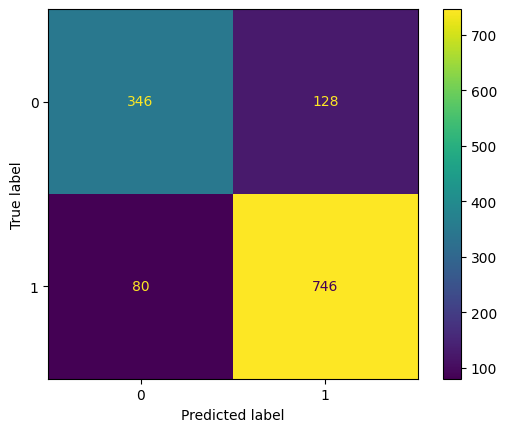

Classification Report for RandomForestClassifier:
              precision    recall  f1-score   support

           0       0.81      0.73      0.77       474
           1       0.85      0.90      0.88       826

    accuracy                           0.84      1300
   macro avg       0.83      0.82      0.82      1300
weighted avg       0.84      0.84      0.84      1300



In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.impute import SimpleImputer
import pickle
import warnings

warnings.filterwarnings('ignore')

# Load the dataset
df = pd.read_csv('E:/BDA_PROJECT/winequalityN.csv')
print("Dataset Head:")
print(df.head())
print("\nDataset Info:")
df.info()
print("\nMissing Values:")
print(df.isnull().sum())

# Handle missing values by filling with column mean
for col in df.columns:
    if df[col].isnull().sum() > 0:
        df[col] = df[col].fillna(df[col].mean())

print(f"Total Missing Values After Imputation: {df.isnull().sum().sum()}")

# Drop 'total sulfur dioxide' (not useful after correlation analysis)
df = df.drop('total sulfur dioxide', axis=1)

# Create target variable: 'best quality' (quality > 5 is best)
df['best quality'] = [1 if x > 5 else 0 for x in df.quality]

# Replace wine type ('white' -> 1, 'red' -> 0)
df.replace({'white': 1, 'red': 0}, inplace=True)

# Define features and target
features = df.drop(['quality', 'best quality'], axis=1)
target = df['best quality']

# Split the data into training and test sets
xtrain, xtest, ytrain, ytest = train_test_split(features, target, test_size=0.2, random_state=40)

# Impute missing values in case of splits
imputer = SimpleImputer(strategy='mean')
xtrain = imputer.fit_transform(xtrain)
xtest = imputer.transform(xtest)

# Save the imputer for future use
with open('Imputer.pkl', 'wb') as imputer_file:
    pickle.dump(imputer, imputer_file)

# Normalize the data using MinMaxScaler
scaler = MinMaxScaler()
xtrain = scaler.fit_transform(xtrain)
xtest = scaler.transform(xtest)

# Save the scaler for future use
with open('Scaler.pkl', 'wb') as scaler_file:
    pickle.dump(scaler, scaler_file)

# Train multiple models
models = [
    LogisticRegression(),
    XGBClassifier(),
    SVC(kernel='rbf'),
    RandomForestClassifier(n_estimators=100, random_state=40)
]

# Dictionary to store model accuracies
model_accuracies = {}

# Train and evaluate each model
for model in models:
    model.fit(xtrain, ytrain)
    
    # Calculate training and validation accuracy
    train_accuracy = metrics.roc_auc_score(ytrain, model.predict(xtrain))
    val_accuracy = metrics.roc_auc_score(ytest, model.predict(xtest))
    print(f'{model.__class__.__name__}:')
    print(f'Training Accuracy : {train_accuracy:.4f}')
    print(f'Validation Accuracy : {val_accuracy:.4f}\n')
    
    # Store validation accuracy
    model_accuracies[model.__class__.__name__] = val_accuracy

# Determine the best model based on validation accuracy
best_model_name = max(model_accuracies, key=model_accuracies.get)
best_model = [model for model in models if model.__class__.__name__ == best_model_name][0]

# Save the best model
with open('Best_Model.pkl', 'wb') as best_model_file:
    pickle.dump(best_model, best_model_file)

print(f'The best model is {best_model_name} with Validation Accuracy: {model_accuracies[best_model_name]:.4f}')
print('Best model saved as Best_Model.pkl')

# Evaluate the best model
cm = confusion_matrix(ytest, best_model.predict(xtest))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(target))
disp.plot()
plt.show()

print(f"Classification Report for {best_model_name}:")
print(classification_report(ytest, best_model.predict(xtest)))


In [8]:
!pip install pyspark

In [10]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, LogisticRegression, GBTClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import pickle

# Initialize Spark session
spark = SparkSession.builder.appName("WineQualityPrediction").getOrCreate()

# Load the data from CSV
df = spark.read.csv("E:\BDA_PROJECT\winequalityN.csv", header=True, inferSchema=True)

# Drop the 'total_sulfur_dioxide' column
df = df.drop('total_sulfur_dioxide')

# Convert the 'type' column to numeric (white wine = 0, red wine = 1)
from pyspark.sql.functions import when
df = df.withColumn('type', when(df['type'] == 'white', 0).otherwise(1))

# Define features and label
feature_columns = ['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar', 'chlorides',
                   'free_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol']
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df = assembler.transform(df)

# Split the data into training and test sets
train_data, test_data = df.randomSplit([0.8, 0.2], seed=123)

# Define models
models = {
    'DecisionTree': DecisionTreeClassifier(labelCol='quality', featuresCol='features'),
    'RandomForest': RandomForestClassifier(labelCol='quality', featuresCol='features'),
    'LogisticRegression': LogisticRegression(labelCol='quality', featuresCol='features'),
    'GBT': GBTClassifier(labelCol='quality', featuresCol='features')
}

# Create a pipeline
pipeline = Pipeline(stages=[assembler])

# Evaluate the models
evaluator = MulticlassClassificationEvaluator(labelCol='quality', predictionCol='prediction', metricName='accuracy')

for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    # Create a pipeline with the current model
    model_pipeline = Pipeline(stages=[assembler, model])
    # Fit the model
    model_trained = model_pipeline.fit(train_data)
    # Make predictions
    predictions = model_trained.transform(test_data)
    # Evaluate accuracy
    accuracy = evaluator.evaluate(predictions)
    print(f"Accuracy of {model_name}: {accuracy:.4f}")
    
    # Save the trained model as a .pkl file
    with open(f'{model_name}_model.pkl', 'wb') as f:
        pickle.dump(model_trained, f)

spark.stop()


ModuleNotFoundError: No module named 'pyspark'